In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

## Config

In [2]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

## Agreement Score Optimization

### DICE

In [3]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wdice.pkl"))

mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
mdl_preds_sorted.head()
mdl_preds_sorted.columns

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_consensus_chs', 'ueo_consensus_strict_dice',
       'ueo_consensus_loose_dice', 'ueo_any_chs', 'ueo_any_strict_dice',
       'ueo_any_loose_dice', 'sec_consensus_chs', 'sec_consensus_strict_dice',
       'sec_consensus_loose_dice', 'sec_any_chs', 'sec_any_strict_dice',
       'sec_any_loose_dice'],
      dtype='object')

In [4]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.727273,0.571429,"[LB01, LB02, LB03, LC01, LC02]",0.312500,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.666667,0.578947,ueo_consensus_strict_dice,0.687500
2,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.142012,0.126984,"[LB01, LB02, LB03, LC01, LC02]",0.054945,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.130952,0.117021,ueo_consensus_strict_dice,0.130952
3,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.727273,0.571429,"[LB01, LB02, LB03, LC01, LC02]",0.312500,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.666667,0.578947,ueo_consensus_strict_dice,0.687500
4,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.143713,0.127660,"[LB01, LB02, LB03, LC01, LC02]",0.055249,"[LA01, LA02, LA03, LA04, LB01, LB02, LB03, LB0...",0.133333,0.117647,ueo_consensus_strict_dice,0.132530


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

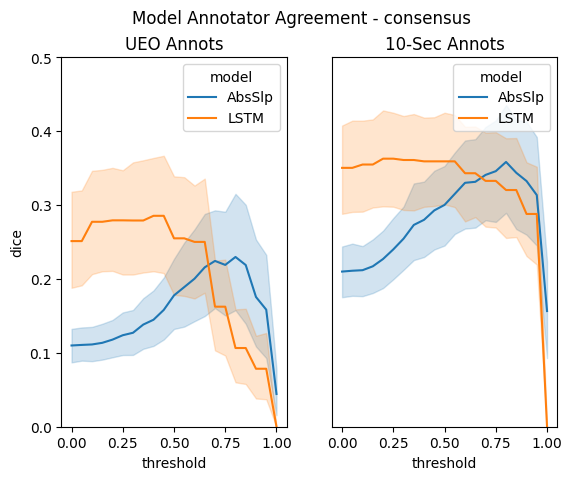

In [5]:
fig,axs = plt.subplots(1,2)
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[0])
axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_{anntype}_{mdl_anntype}_dice'],x='threshold',y='dice',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Kappa

In [12]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"predicted_channels_wkappa.pkl"))
# mdl_preds = mdl_preds[mdl_preds.stim == 0]
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])
# mdl_preds_sorted.head()

In [25]:
melt_cols = [f'ueo_chs_{mdl_anntype}_{anntype}_kappa',f'sec_chs_{mdl_anntype}_{anntype}_kappa']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='kappa')
print(np.sort(mdl_preds.columns))
mdl_preds_long.head()

['Patient' 'all_chs' 'approximate_onset' 'iEEG_ID' 'model' 'sec_any'
 'sec_chs_loose' 'sec_chs_strict' 'sec_chs_strict_any_kappa'
 'sec_chs_strict_bool' 'sec_chs_strict_consensus_kappa' 'sec_consensus'
 'stim' 'threshold' 'to_annotate' 'ueo_any' 'ueo_chs_loose'
 'ueo_chs_loose_any_kappa' 'ueo_chs_loose_bool'
 'ueo_chs_loose_consensus_kappa' 'ueo_chs_strict'
 'ueo_chs_strict_any_kappa' 'ueo_chs_strict_bool'
 'ueo_chs_strict_consensus_kappa' 'ueo_consensus' 'ueo_time_consensus']


,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,sec_any,ueo_chs_strict_bool,ueo_chs_strict_any_kappa,ueo_chs_loose_bool,ueo_chs_loose_consensus_kappa,ueo_chs_loose_any_kappa,sec_chs_strict_bool,sec_chs_strict_any_kappa,annot,kappa
0,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.049912,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,ueo_chs_strict_consensus_kappa,0.045643
1,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.00,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, False, False, False, ...",0.707875,"[True, True, True, True, True, False, False, F...",0.501710,0.536913,"[True, True, True, True, False, False, False, ...",0.645171,ueo_chs_strict_consensus_kappa,0.666570
2,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.049912,"[True, True, True, True, True, True, True, Tru...",0.029635,0.032431,"[True, True, True, True, True, True, True, Tru...",0.045643,ueo_chs_strict_consensus_kappa,0.045643
3,HUP224,HUP224_phaseII,LSTM,1.0,71156.59,71156.59,0.05,"[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...","[LA01, LA02, LA03, LA04, LA05, LA09, LA10, LB0...","[LA01, LA02, LA03, LA04, LA09, LB01, LB02, LB0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, False, False, False, ...",0.707875,"[True, True, True, True, True, False, False, F...",0.501710,0.536913,"[True, True, True, True, False, False, False, ...",0.645171,ueo_chs_strict_consensus_kappa,0.666570
4,HUP224,HUP224_phaseII,AbsSlp,1.0,71156.59,71156.59,0.10,"[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, True, True, True, Tru...",0.051888,"[True, True, True, True, True, True, True, Tru...",0.030354,0.033217,"[True, True, True, True, True, True, True, Tru...",0.048377,ueo_chs_strict_consensus_kappa,0.047455


Text(0.5, 0.98, 'Model Annotator Agreement - consensus')

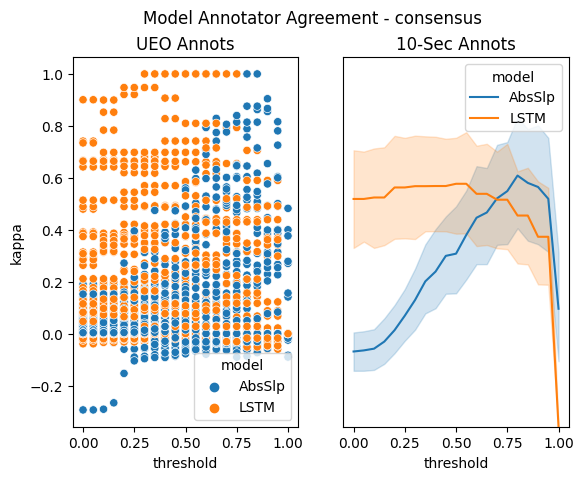

In [17]:
fig,axs = plt.subplots(1,2)
sns.scatterplot(data=mdl_preds_long[mdl_preds_long.annot == f'ueo_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[0])
# axs[0].set_ylim((0,.5))
axs[0].set_title('UEO Annots')
sns.lineplot(data=mdl_preds_long[mdl_preds_long.annot == f'sec_chs_{mdl_anntype}_{anntype}_kappa'],x='threshold',y='kappa',hue='model',ax=axs[1])
axs[1].set_ylim((0,.5))
axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].set_title('10-Sec Annots')
fig.suptitle(f'Model Annotator Agreement - {anntype}')

### Getting optimal threshold

In [30]:
mask = mdl_preds_sorted.model == 'LSTM'
print(mdl_preds.columns)
ueo_df = mdl_preds_sorted[mask].groupby('threshold')['ueo_chs_strict_consensus_kappa'].mean()
sec_df = mdl_preds_sorted[mask].groupby('threshold')['sec_chs_strict_consensus_kappa'].mean()

Index(['Patient', 'iEEG_ID', 'model', 'stim', 'approximate_onset',
       'ueo_time_consensus', 'threshold', 'ueo_chs_strict', 'ueo_chs_loose',
       'sec_chs_strict', 'sec_chs_loose', 'to_annotate', 'all_chs',
       'ueo_consensus', 'ueo_any', 'sec_consensus', 'sec_any',
       'ueo_chs_strict_bool', 'ueo_chs_strict_consensus_kappa',
       'ueo_chs_strict_any_kappa', 'ueo_chs_loose_bool',
       'ueo_chs_loose_consensus_kappa', 'ueo_chs_loose_any_kappa',
       'sec_chs_strict_bool', 'sec_chs_strict_consensus_kappa',
       'sec_chs_strict_any_kappa'],
      dtype='object')


In [34]:
ueo_df.iloc[:].argmax()

8

In [38]:
print(ueo_df.index[ueo_df.iloc[:].argmax()])
print(sec_df.index[sec_df.iloc[:].argmax()])

0.4
0.5
